In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# E2E ABSA

In [ ]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xml.etree.ElementTree as ET
import re
import contractions


# Function to preprocess text
def preprocess_text(text):
     # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove all punctuation and special characters (keeping only alphanumeric and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # 3. Expand contractions
    text = contractions.fix(text)

    # 4. Replace numbers with a placeholder token
    text = re.sub(r'\d+', 'NUM', text)

    return text

# Function to parse the XML file
def parse_xml_to_sentences(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    data = []

    for sentence in root.findall('sentence'):
        sent_id = sentence.get('id')
        text = sentence.find('text').text
        text = preprocess_text(text)
        aspect_terms = []

        # Find aspect terms and their attributes
        aspect_terms_element = sentence.find('aspectTerms')
        if aspect_terms_element:
            for aspect_term in aspect_terms_element.findall('aspectTerm'):
                term = aspect_term.get('term')
                term = preprocess_text(aspect_term.get('term'))
                polarity = aspect_term.get('polarity')
                start = int(aspect_term.get('from'))
                end = int(aspect_term.get('to'))
                aspect_terms.append((term, start, end, polarity))

        data.append({
            'id': sent_id,
            'text': text,
            'aspect_terms': aspect_terms
        })

    return data

# Example usage
xml_file = '/content/drive/MyDrive/CS686 Project/Laptops_Train.xml'
dataset = parse_xml_to_sentences(xml_file)


In [ ]:
# Example usage
xml_file_test = '//content/drive/MyDrive/CS686 Project/laptops-trial.xml'
dataset_test = parse_xml_to_sentences(xml_file_test)

In [ ]:
from transformers import BertTokenizer
from nltk.tokenize import word_tokenize

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to generate BIESO tags for a tokenized sentence using BERT's tokenizer
def generate_bio_p_tags_bert(tokens, aspect_terms, bert_tokens):
    tags = ['O'] * len(bert_tokens)  # Initialize all tags as 'O'

    for aspect_term, start, end, polarity in aspect_terms:
        # Tokenize the aspect term
        aspect_tokens = tokenizer.tokenize(aspect_term)
        aspect_length = len(aspect_tokens)

        # Determine the polarity tag (POS, NEG, NEU)
        if polarity == "positive":
            polarity_tag = "POS"
        elif polarity == "negative":
            polarity_tag = "NEG"
        else:
            polarity_tag = "NEU"

        # Find matching subword tokens in BERT's tokenized sentence
        for i in range(len(bert_tokens) - aspect_length + 1):
            if bert_tokens[i:i + aspect_length] == aspect_tokens:
                # Assign tags based on the length of the aspect term
                if aspect_length == 1:
                    # Singleton aspect term
                    tags[i] = f'S-{polarity_tag}'
                else:
                    # Multi-token aspect term
                    tags[i] = f'B-{polarity_tag}'  # Beginning tag
                    for j in range(1, aspect_length - 1):
                        tags[i + j] = f'I-{polarity_tag}'  # Inside tags
                    tags[i + aspect_length - 1] = f'E-{polarity_tag}'  # Ending tag

    return tags


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Example usage
sentence_data = dataset[2]
text = sentence_data['text']
aspect_terms = sentence_data['aspect_terms']

print("Text:", text)
print("Aspect Terms:", aspect_terms)

# Tokenize the sentence with BERT tokenizer
bert_tokens = tokenizer.tokenize(text)
bert_token_ids = tokenizer.convert_tokens_to_ids(bert_tokens)

# Generate BIO-P tags directly with BERT's tokenizer
bio_p_tags = generate_bio_p_tags_bert(bert_tokens, aspect_terms, bert_tokens)

# Output the tokens and tags
print("BERT Tokens:", bert_tokens)
print("BIO-P Tags:", bio_p_tags)

Text: the tech guy then said the service center does not do NUMtoNUM exchange and i have to direct my concern to the sales team which is the retail shop which i bought my netbook from
Aspect Terms: [('service center', 27, 41, 'negative'), ('sales team', 109, 121, 'negative'), ('tech guy', 4, 12, 'neutral')]
BERT Tokens: ['the', 'tech', 'guy', 'then', 'said', 'the', 'service', 'center', 'does', 'not', 'do', 'nu', '##mt', '##on', '##um', 'exchange', 'and', 'i', 'have', 'to', 'direct', 'my', 'concern', 'to', 'the', 'sales', 'team', 'which', 'is', 'the', 'retail', 'shop', 'which', 'i', 'bought', 'my', 'net', '##book', 'from']
BIO-P Tags: ['O', 'B-NEU', 'E-NEU', 'O', 'O', 'O', 'B-NEG', 'E-NEG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NEG', 'E-NEG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd


# Convert to DataFrame
def create_bio_p_dataframe(dataset):
    sentences = []
    token_lists = []
    tag_lists = []

    for data in dataset:
        tokens = word_tokenize(data['text'])  # Tokenize sentence
        bert_tokens = tokenizer.tokenize(data['text'])  # Tokenize sentence with BERT's tokenizer
        tags = generate_bio_p_tags_bert(tokens, data['aspect_terms'], bert_tokens)  # Generate BIO-P tags

        sentences.append(data['text'])
        token_lists.append(bert_tokens)
        tag_lists.append(tags)

    # Create a DataFrame
    df = pd.DataFrame({
        'Sentence': sentences,
        'Tokens': token_lists,
        'Tags': tag_lists
    })

    return df

# Create DataFrame from the dataset
df_bio_p = create_bio_p_dataframe(dataset)

# Save DataFrame to CSV (if needed)
df_bio_p.to_csv('/content/drive/MyDrive/CS686 Project/laptop_train.csv', index=False)

# Display the DataFrame
print(len(df_bio_p))
df_bio_p.head()


3048


,Sentence,Tokens,Tags
0,i charge it at night and skip taking the cord ...,"[i, charge, it, at, night, and, skip, taking, ...","[O, O, O, O, O, O, O, O, O, S-NEU, O, O, O, O,..."
1,i bought a hp pavilion dvNUMnr laptop and have...,"[i, bought, a, hp, pavilion, d, ##vn, ##um, ##...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,the tech guy then said the service center does...,"[the, tech, guy, then, said, the, service, cen...","[O, B-NEU, E-NEU, O, O, O, B-NEG, E-NEG, O, O,..."
3,i investigated netbooks and saw the toshiba nb...,"[i, investigated, net, ##books, and, saw, the,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,the other day i had a presentation to do for a...,"[the, other, day, i, had, a, presentation, to,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
print(df_bio_p.iloc[2]['Sentence'])
print(df_bio_p.iloc[2]['Tags'])

the tech guy then said the service center does not do NUMtoNUM exchange and i have to direct my concern to the sales team which is the retail shop which i bought my netbook from
['O', 'B-NEU', 'E-NEU', 'O', 'O', 'O', 'B-NEG', 'E-NEG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NEG', 'E-NEG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


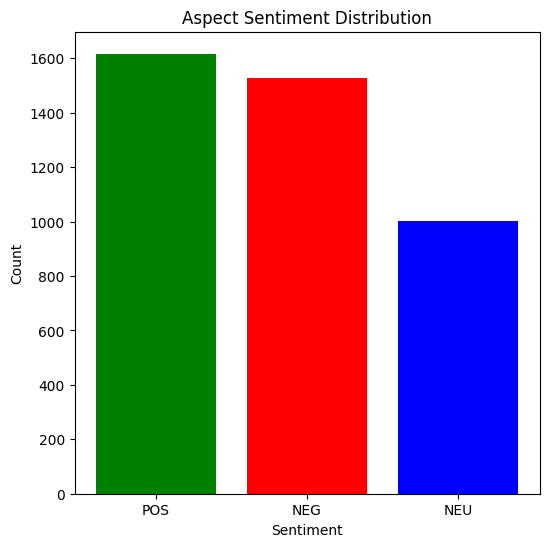

In [ ]:
# 3. Aspect Sentiment Distribution (POS, NEG, NEU)
sentiment_tags = ['POS', 'NEG', 'NEU']
sentiment_counts = {sent: sum(1 for tag in all_tags if sent in tag) for sent in sentiment_tags}
plt.figure(figsize=(6, 6))
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['green', 'red', 'blue'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Aspect Sentiment Distribution")
plt.show()

In [ ]:
from collections import Counter
import pandas as pd

# Assuming df_bio_p is already created and contains a 'Tags' column with lists of tags for each sentence

# Flatten the list of tags across all sentences
all_tags = [tag for tags in df_bio_p['Tags'] for tag in tags]

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

print("Tag counts:", tag_counts)


Tag counts: Counter({'O': 44773, 'S-POS': 613, 'E-NEG': 439, 'B-NEG': 438, 'S-NEG': 431, 'B-POS': 385, 'E-POS': 384, 'B-NEU': 305, 'E-NEU': 305, 'I-POS': 235, 'I-NEG': 220, 'S-NEU': 199, 'I-NEU': 194})


In [ ]:
from collections import Counter
import pandas as pd

# Check the distribution of tags to identify underrepresented ones
all_tags = [tag for tags in df_bio_p['Tags'] for tag in tags]
tag_counts = Counter(all_tags)
print("Original tag distribution:", tag_counts)

# Define a threshold for underrepresented classes (e.g., tags with fewer than 10 occurrences)
underrepresented_tags = {tag for tag, count in tag_counts.items() if count < 1000}

# Filter sentences that contain any of the underrepresented tags
underrepresented_rows = df_bio_p[df_bio_p['Tags'].apply(lambda tags: any(tag in underrepresented_tags for tag in tags))]

# Set a fixed upsampling factor for underrepresented rows
upsample_factor = 3  # Adjust this based on your dataset and computing resources

# Repeat underrepresented rows with a fixed upsampling factor
df_upsampled = pd.concat([df_bio_p] + [underrepresented_rows] * upsample_factor)

# Shuffle the upsampled DataFrame
df_upsampled = df_upsampled.sample(frac=1).reset_index(drop=True)


all_tags = [tag for tags in df_upsampled['Tags'] for tag in tags]
tag_counts = Counter(all_tags)
print("Upsampled tag distribution:", tag_counts)
print(len(df_upsampled))
df_upsampled.head()


Original tag distribution: Counter({'O': 44773, 'S-POS': 613, 'E-NEG': 439, 'B-NEG': 438, 'S-NEG': 431, 'B-POS': 385, 'E-POS': 384, 'B-NEU': 305, 'E-NEU': 305, 'I-POS': 235, 'I-NEG': 220, 'S-NEU': 199, 'I-NEU': 194})
Upsampled tag distribution: Counter({'O': 116389, 'S-POS': 2452, 'E-NEG': 1756, 'B-NEG': 1752, 'S-NEG': 1724, 'B-POS': 1540, 'E-POS': 1536, 'B-NEU': 1220, 'E-NEU': 1220, 'I-POS': 940, 'I-NEG': 880, 'S-NEU': 796, 'I-NEU': 776})
7512


,Sentence,Tokens,Tags
0,for those old enough to remember it is similar...,"[for, those, old, enough, to, remember, it, is...","[O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,the benefits were immediate,"[the, benefits, were, immediate]","[O, O, O, O]"
2,obviously one of the most important features o...,"[obviously, one, of, the, most, important, fea...","[O, O, O, O, O, O, S-NEU, O, O, O, O, O, B-NEU..."
3,i especially like the backlit keyboard,"[i, especially, like, the, back, ##lit, keyboard]","[O, O, O, O, B-POS, I-POS, E-POS]"
4,a tip for people looking into this computer do...,"[a, tip, for, people, looking, into, this, com...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
# Create DataFrame from the dataset
df_test = create_bio_p_dataframe(dataset_test)

# Save DataFrame to CSV (if needed)
df_test.to_csv('/content/drive/MyDrive/CS686 Project/Laptops_Test_Data_PhaseA.csv', index=False)

# Display the DataFrame
print(len(df_test))
df_test.head()

100


,Sentence,Tokens,Tags
0,i liked the aluminum body,"[i, liked, the, aluminum, body]","[O, O, O, B-POS, E-POS]"
1,lightweight and the screen is beautiful,"[lightweight, and, the, screen, is, beautiful]","[O, O, O, S-POS, O, O]"
2,buy it love it and i promise you will not regr...,"[buy, it, love, it, and, i, promise, you, will...","[O, O, O, O, O, O, O, O, O, O, O, O]"
3,from the build quality to the performance ever...,"[from, the, build, quality, to, the, performan...","[O, O, B-NEG, E-NEG, O, O, S-NEG, O, O, O, O, ..."
4,pretty much everything else about the computer...,"[pretty, much, everything, else, about, the, c...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
import torch
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tag to ID mapping
tag_to_id = {
    'O': 0,               # Outside of aspect terms
    'B-POS': 1,           # Beginning of a positive aspect term
    'I-POS': 2,           # Inside of a positive aspect term
    'E-POS': 3,           # End of a positive aspect term
    'S-POS': 4,           # Singleton positive aspect term
    'B-NEG': 5,           # Beginning of a negative aspect term
    'I-NEG': 6,           # Inside of a negative aspect term
    'E-NEG': 7,           # End of a negative aspect term
    'S-NEG': 8,           # Singleton negative aspect term
    'B-NEU': 9,           # Beginning of a neutral aspect term
    'I-NEU': 10,          # Inside of a neutral aspect term
    'E-NEU': 11,          # End of a neutral aspect term
    'S-NEU': 12           # Singleton neutral aspect term
}
padding_label = -100  # This should not overlap with any tag ID in `tag_to_id`

# Preprocessing function to align tokens and tags for BERT
def preprocess_for_bert(df):
    input_ids = []
    attention_masks = []
    label_ids = []

    for i, row in df.iterrows():
        sentence = row['Sentence']
        tokens = row['Tokens']
        tags = row['Tags']

        # Tokenize using BERT's tokenizer
        bert_tokens = []
        aligned_tags = []

        for word, tag in zip(tokens, tags):
            word_tokens = tokenizer.tokenize(word)  # Tokenize the word into subwords
            bert_tokens.extend(word_tokens)  # Add subwords to the token list

            # Assign the tag to the first subword, and pad others with "O"
            aligned_tags.append(tag_to_id[tag])
            aligned_tags.extend([tag_to_id['O']] * (len(word_tokens) - 1))

        # Convert tokens to input IDs
        input_id = tokenizer.convert_tokens_to_ids(bert_tokens)

        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = [1] * len(input_id)

        # Add to lists
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        label_ids.append(aligned_tags)

    # Pad input and label sequences to match max length
    max_len = max(len(seq) for seq in input_ids)

    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", value=0, padding="post", truncating="post")
    attention_masks = pad_sequences(attention_masks, maxlen=max_len, dtype="long", value=0, padding="post", truncating="post")
    label_ids = pad_sequences(label_ids, maxlen=max_len, dtype="long", value=tag_to_id['O'], padding="post", truncating="post")

    return torch.tensor(input_ids), torch.tensor(attention_masks), torch.tensor(label_ids)

# Preprocess the data for BERT
X_input_ids, X_attention_masks, y_labels = preprocess_for_bert(df_upsampled)


In [ ]:
print(X_input_ids)
print(X_attention_masks)
print(y_labels)

tensor([[2005, 2216, 2214,  ...,    0,    0,    0],
        [1996, 6666, 2020,  ...,    0,    0,    0],
        [5525, 2028, 1997,  ...,    0,    0,    0],
        ...,
        [1045, 2572, 2183,  ...,    0,    0,    0],
        [2009, 2003, 2036,  ...,    0,    0,    0],
        [3154, 3861, 2006,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 4, 0,  ..., 0, 0, 0]])


#CRF Layer

In [ ]:
pip install torchcrf

In [ ]:
!pip install pytorch-crf

In [ ]:
import torch
import torch.nn as nn
from transformers import BertForTokenClassification
from transformers import BertModel
from torchcrf import CRF
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Define a custom BERT model with a CRF layer on top
class BertCRFModel(nn.Module):
    def __init__(self, base_model, num_labels,tag_weights=None):
    # def __init__(self, num_labels,num_frozen_layers=8):
        super(BertCRFModel, self).__init__()
        # Load BERT model as the base
        self.bert = base_model.bert  # Reuse the BERT model from an existing BERT for token classification
        # self.bert = BertModel.from_pretrained('bert-base-uncased',hidden_dropout_prob=0.3)
        # self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.classifier = nn.Linear(base_model.config.hidden_size, num_labels)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        self.tag_weights = tag_weights if tag_weights is not None else torch.ones(num_labels, device=device)

        # Freeze the first few layers of BERT
        # for layer in self.bert.encoder.layer[:num_frozen_layers]:
        #     for param in layer.parameters():
        #         param.requires_grad = False

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Forward pass through BERT
        # Get hidden states from all layers
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-4:]  # Take the last 4 layers
        # Average the last 4 layers
        layer_output = torch.mean(torch.stack(hidden_states), dim=0)
        logits = self.classifier(layer_output)

        # If labels are provided, calculate CRF loss
        if labels is not None:
            # Negative log likelihood loss for CRF
            loss = -self.crf(logits, labels, mask=attention_mask.bool())
            # weighted_loss = (loss * self.tag_weights[labels]).mean()
            # return weighted_loss
            return loss
        else:
            # Decode the tags using CRF
            return self.crf.decode(logits, mask=attention_mask.bool())


tag_counts_list = [tag_counts.get(tag, 0) for tag in tag_to_id.keys()]

# Convert counts to tensor and calculate inverse frequency
tag_counts_tensor = torch.tensor(tag_counts_list, dtype=torch.float32)
tag_weights = 1.0 / tag_counts_tensor  # Inverse frequency

# Optional: Normalize weights to ensure they sum to the number of tags
tag_weights = tag_weights / tag_weights.sum() * len(tag_counts_list)

# Set up the model with the CRF layer and tag weights
num_labels = len(tag_to_id)  # Make sure this matches your tag set
base_model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=num_labels, hidden_dropout_prob=0.2)
model = BertCRFModel(base_model, num_labels=num_labels).to(device)



Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

optimizer = AdamW(model.parameters(), lr=1e-5)



Epoch 1/3
Average Training Loss: 34.50
Training Accuracy: 0.97
Training Precision: 0.96
Training Recall: 0.97
Average Validation Loss: 32.22
Validation Accuracy: 0.97
Validation Precision: 0.97
Validation Recall: 0.97
Epoch 2/3
Average Training Loss: 26.23
Training Accuracy: 0.97
Training Precision: 0.97
Training Recall: 0.97
Average Validation Loss: 25.01
Validation Accuracy: 0.98
Validation Precision: 0.98
Validation Recall: 0.98
Epoch 3/3
Average Training Loss: 22.20
Training Accuracy: 0.98
Training Precision: 0.98
Training Recall: 0.98
Average Validation Loss: 23.45
Validation Accuracy: 0.98
Validation Precision: 0.98
Validation Recall: 0.98


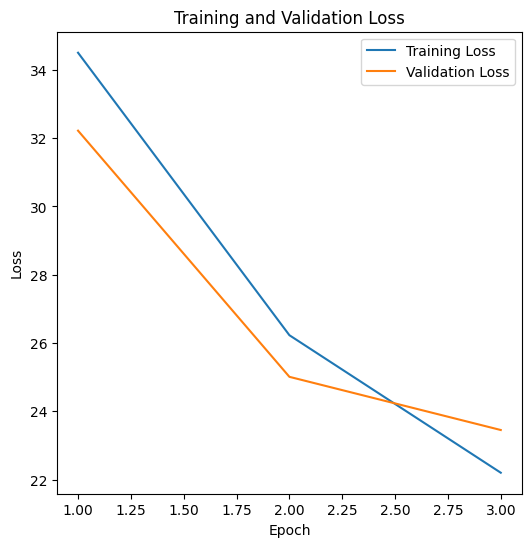

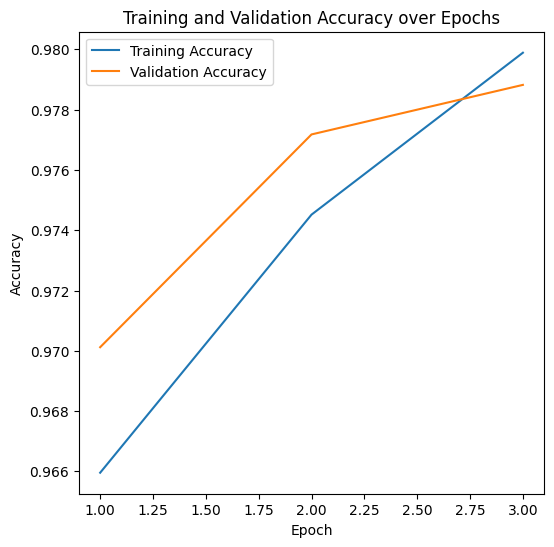

In [ ]:
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_

from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from transformers import get_linear_schedule_with_warmup

# max_grad_norm = 1.0

# Train/test split
X_train_ids, X_val_ids, X_train_mask, X_val_mask, y_train, y_val = train_test_split(
    X_input_ids, X_attention_masks, y_labels, test_size=0.2, random_state=42
)

# Create DataLoader
train_data = TensorDataset(X_train_ids, X_train_mask, y_train)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=16)

# Prepare validation DataLoader
val_data = TensorDataset(X_val_ids, X_val_mask, y_val)
val_dataloader = DataLoader(val_data, sampler=RandomSampler(val_data), batch_size=16)

# Initialize lists to store loss values
train_losses = []
val_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
val_accuracies = []
val_precisions = []
val_recalls = []

epochs = 3

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # Warmup for 10% of training steps
    num_training_steps=total_steps
)

# for i in range(3):
#     print("Experiment: ", i+1)

for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()  # Set model to training mode

        total_loss = 0
        all_train_preds = []
        all_train_labels = []
        for batch in train_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)

            # Clear previous gradients
            model.zero_grad()

            # Forward pass
            loss = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
            total_loss += loss.item()

            # Backward pass
            loss.backward()

            # Clip gradients
            # clip_grad_norm_(model.parameters(), max_grad_norm)

            # Update parameters
            optimizer.step()

            # Update learning rate
            scheduler.step()  # This line updates the learning rate

            # Get predictions for training metrics
            train_preds = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            all_train_preds.extend(train_preds)
            all_train_labels.extend(batch_labels.cpu().numpy())

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Average Training Loss: {avg_train_loss:.2f}")

        truncated_predicted_tags_train = []
        truncated_true_tags_train = []

        for pred_seq, true_seq in zip(all_train_preds, all_train_labels):
          min_length = min(len(pred_seq), len(true_seq))  # Find the minimum length for this pair
          truncated_predicted_tags_train.append(pred_seq[:min_length])  # Truncate predicted tags
          truncated_true_tags_train.append(true_seq[:min_length])  # Truncate true tags

        true_tags_flat_train = [tag for sentence in truncated_true_tags_train for tag in sentence]
        predicted_tags_flat_train = [tag for sentence in truncated_predicted_tags_train for tag in sentence]


        train_accuracy = accuracy_score(true_tags_flat_train, predicted_tags_flat_train)
        train_precision = precision_score(true_tags_flat_train, predicted_tags_flat_train, average='weighted')
        train_recall = recall_score(true_tags_flat_train, predicted_tags_flat_train, average='weighted')

        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)

        print(f"Training Accuracy: {train_accuracy:.2f}")
        print(f"Training Precision: {train_precision:.2f}")
        print(f"Training Recall: {train_recall:.2f}")

        # Validation step
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)

                # Forward pass
                loss = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
                val_loss += loss.item()

                # Get predictions
                val_preds = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
                all_val_preds.extend(val_preds)
                all_val_labels.extend(batch_labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        print(f"Average Validation Loss: {avg_val_loss:.2f}")

        truncated_predicted_tags_val = []
        truncated_true_tags_val = []

        for pred_seq, true_seq in zip(all_val_preds, all_val_labels):
          min_length = min(len(pred_seq), len(true_seq))  # Find the minimum length for this pair
          truncated_predicted_tags_val.append(pred_seq[:min_length])  # Truncate predicted tags
          truncated_true_tags_val.append(true_seq[:min_length])  # Truncate true tags

        true_tags_flat_val = [tag for sentence in truncated_true_tags_val for tag in sentence]
        predicted_tags_flat_val = [tag for sentence in truncated_predicted_tags_val for tag in sentence]




        # # Calculate validation metrics
        val_accuracy = accuracy_score(true_tags_flat_val, predicted_tags_flat_val)
        val_precision = precision_score(true_tags_flat_val, predicted_tags_flat_val, average='weighted')
        val_recall = recall_score(true_tags_flat_val, predicted_tags_flat_val, average='weighted')

        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        print(f"Validation Accuracy: {val_accuracy:.2f}")
        print(f"Validation Precision: {val_precision:.2f}")
        print(f"Validation Recall: {val_recall:.2f}")

        # Save the model at the end of each epoch
        # torch.save(model.state_dict(), "/content/drive/MyDrive/CS686 Project/bert_model_with_crf.pth")
        # print("Model saved")

    # Plotting the training and validation losses
plt.figure(figsize=(6, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


        # Plotting accuracy, precision, and recall over epochs for both training and validation
plt.figure(figsize=(6, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()



In [ ]:
# Assuming df_test is your test DataFrame and contains columns: 'Sentence', 'Tokens', and 'Tags'
sentence_predictions = []

# Preprocess function to tokenize and align tokens for BERT
def preprocess_for_bert(df):
    input_ids = []
    attention_masks = []
    label_ids = []

    for i, row in df.iterrows():
        sentence = row['Sentence']
        tokens = row['Tokens']
        tags = row['Tags']

        # Tokenize using BERT's tokenizer
        bert_tokens = []
        aligned_tags = []

        for word, tag in zip(tokens, tags):
            word_tokens = tokenizer.tokenize(word)  # Tokenize the word into subwords
            bert_tokens.extend(word_tokens)  # Add subwords to the token list

            # Assign the tag to the first subword, and pad others with "O"
            aligned_tags.append(tag_to_id[tag])
            aligned_tags.extend([tag_to_id['O']] * (len(word_tokens) - 1))

        # Convert tokens to input IDs
        input_id = tokenizer.convert_tokens_to_ids(bert_tokens)

        # Create attention mask (1 for real tokens, 0 for padding)
        attention_mask = [1] * len(input_id)

        # Add to lists
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        label_ids.append(aligned_tags)

    # Pad input and label sequences to match max length
    max_len = max(len(seq) for seq in input_ids)

    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", value=0, padding="post", truncating="post")
    attention_masks = pad_sequences(attention_masks, maxlen=max_len, dtype="long", value=0, padding="post", truncating="post")
    label_ids = pad_sequences(label_ids, maxlen=max_len, dtype="long", value=tag_to_id['O'], padding="post", truncating="post")

    return torch.tensor(input_ids), torch.tensor(attention_masks), torch.tensor(label_ids)

# Preprocess the test dataframe
X_test_input_ids, X_test_attention_masks, y_test_labels = preprocess_for_bert(df_test)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler

# Create a DataLoader for the test data
test_data = TensorDataset(X_test_input_ids, X_test_attention_masks, y_test_labels)
test_dataloader = DataLoader(test_data, sampler=RandomSampler(test_data), batch_size=16)  # Use an appropriate batch size


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Set the model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# No gradient calculation needed for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = tuple(t.to(device) for t in batch)

        # Get predictions from the model (CRF decoding will return tag sequences directly)
        predictions = model(batch_input_ids, attention_mask=batch_attention_masks)

        # Append predictions and true labels for later comparison
        all_preds.extend(predictions)
        all_labels.extend(batch_labels.cpu().numpy().tolist())


In [ ]:
print(all_preds[5])
print(all_labels[5])

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Create a reverse dictionary for ID to tag mapping
id_to_tag = {id_: tag for tag, id_ in tag_to_id.items()}

# Convert predictions and labels to tag names
predicted_tags = [[id_to_tag[tag] for tag in seq] for seq in all_preds]
true_tags = [[id_to_tag[tag] for tag in seq] for seq in all_labels]

print(predicted_tags[5])
print(true_tags[5])



# Truncate each pair of sublists to the minimum length between them
truncated_predicted_tags = []
truncated_true_tags = []

for pred_seq, true_seq in zip(predicted_tags, true_tags):
    min_length = min(len(pred_seq), len(true_seq))  # Find the minimum length for this pair
    truncated_predicted_tags.append(pred_seq[:min_length])  # Truncate predicted tags
    truncated_true_tags.append(true_seq[:min_length])  # Truncate true tags


print(truncated_predicted_tags[5])
print(truncated_true_tags[5])



['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
! pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=3a96ae55ebf01838f5e16e269a573a7c7042d533e1454fbbcfb2f36de9a453de
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
true_tags_flat = [tag for sentence in truncated_true_tags for tag in sentence]
predicted_tags_flat = [tag for sentence in truncated_predicted_tags for tag in sentence]

from sklearn.metrics import classification_report

# Generate the report
print("Classification Report:")
print(classification_report(true_tags_flat, predicted_tags_flat, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

       B-NEG       1.00      0.78      0.88         9
       B-NEU       1.00      0.67      0.80         3
       B-POS       0.67      1.00      0.80        10
       E-NEG       1.00      0.67      0.80         9
       E-NEU       1.00      1.00      1.00         3
       E-POS       0.71      1.00      0.83        10
       I-NEG       0.25      1.00      0.40         1
       I-POS       1.00      1.00      1.00         4
           O       1.00      0.99      0.99      1330
       S-NEG       0.56      0.71      0.62         7
       S-NEU       0.50      1.00      0.67         1
       S-POS       0.69      0.95      0.80        19

    accuracy                           0.98      1406
   macro avg       0.78      0.90      0.80      1406
weighted avg       0.99      0.98      0.98      1406



# Gemini

In [1]:
!pip install -q -U google-generativeai

In [7]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata
userdata.get('Google')
GOOGLE_API_KEY = userdata.get('Google')
genai.configure(api_key=GOOGLE_API_KEY)

In [8]:
model = genai.GenerativeModel('gemini-1.0-pro-001')

In [9]:
sentence= "It was truly a great computer costing less than one thousand bucks before tax."


prompt = f"""
    You are tasked with performing Aspect-Based Sentiment Analysis (ABSA) on the following sentence. Your job is to identify aspect terms in the sentence and assign their corresponding sentiment as Positive, Negative, or Neutral. Present your response in a JSON format where keys are aspect terms and values are their sentiments.

    ### Example:

    Input Sentence: The battery life is amazing and the screen quality is impressive.


    {{
        "battery life": "Positive",
        "screen quality": "Positive"
    }}

    Input Sentence: Buy it, love it, and I promise you won't regret it.
    Output JSON:
    {{}}

    ### Task:
    Now, perform the same task for the following sentence:

{sentence}

Extract the aspect terms and their corresponding sentiment, and present the results in a dictionary with the following format:


{{Aspect Term: Sentiment}}

    ### Important Notes:
    1. Include only terms that can be considered aspects of the reviewed item.
    2. Assign the sentiment based on the sentence's context.
    3. Ensure the response is clear, concise, and in JSON format.
    4. If there are no aspect terms in the sentence, respond with an empty JSON object: {{}}.
    """

In [10]:
response = model.generate_content(prompt)
print(response.text)

```json
{
  "price": "Positive"
}
```
